# Data Preprocessing

In [936]:
import tensorflow as tf
import numpy as np
import pandas as pd
from numpy import genfromtxt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from collections import deque
import numpy as np
import random
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint, EarlyStopping



(600000, 3)
x_0    5500
x_1    5500
x_2    5500
dtype: int64


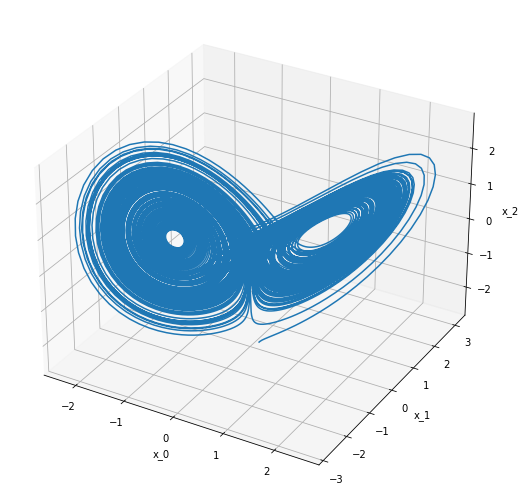

In [937]:
# ## Read the raw data

data = pd.read_csv('normalized_lorenz_0.01.csv')
print(data.shape)
data.head()


fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111, projection = '3d')

data = data.iloc[:20000]

print(plot_data.count())
plot_data.head()
x = data['x_0']
y = data['x_1']
z = data['x_2']

ax.set_xlabel("x_0")
ax.set_ylabel("x_1")
ax.set_zlabel("x_2")

ax.plot(x, y, z)

plt.show()


In [938]:
data.columns

Index(['x_0', 'x_1', 'x_2'], dtype='object')

In [939]:
#Concat all features
df_concat = data
df_concat = df_concat.dropna()
df_concat.shape

(20000, 3)

In [940]:
feat_size = df_concat.shape[1]

print('feature size:', feat_size)

feature size: 3


In [941]:
df_concat.head()

,x_0,x_1,x_2
0,0.131448,0.115472,-2.721660
1,0.133095,0.145388,-2.720358
2,0.137846,0.175781,-2.718737
3,0.145498,0.207373,-2.716736
4,0.155943,0.240839,-2.714263


In [942]:
# how long preceding sequence to consider for prediction
SEQ_LEN = 10    

# How far into the future we are making prediction(10 min in this case)
FUTURE_PERIOD = 10


In [943]:
def classify(current, future):
    if float(future) > float(current):
        return 1
    else:
        return 0

In [944]:
times = sorted(df_concat.index.values)  # get the times
last_10 = sorted(df_concat.index.values)[-int(0.1*len(times))] 
last_20 = sorted(df_concat.index.values)[-int(0.2*len(times))]

test_df = df_concat[(df_concat.index >= last_10)]
validation_df = df_concat[(df_concat.index >= last_20) & (df_concat.index < last_10)]  
train_df = df_concat[(df_concat.index < last_20)]

In [945]:
len(train_df), len(validation_df), len(test_df)

(16000, 2000, 2000)

In [946]:
train_ = train_df.values
valid_ = validation_df.values
test_ = test_df.values

In [947]:
print("train shape {0}".format(train_.shape))
print("valid shape {0}".format(valid_.shape))
print("test shape {0}".format(test_.shape))

train shape (16000, 3)
valid shape (2000, 3)
test shape (2000, 3)


In [948]:
scaler = MinMaxScaler()
scale_close = MinMaxScaler()

In [949]:
x = train_[:,2].copy()
scale_close.fit(x.reshape(-1, 1))

MinMaxScaler()

In [950]:
scaler.fit(train_)

train_ = scaler.transform(train_)
valid_ = scaler.transform(valid_)
test_ = scaler.transform(test_)

In [951]:
def split_data(data):
    X = []
    Y = []
    for i in range(SEQ_LEN, len(data)-FUTURE_PERIOD+1):
        X.append(data[i-SEQ_LEN:i])
        Y.append(data[i+(FUTURE_PERIOD-1), 2])
    return np.array(X), np.array(Y)

In [952]:
X_train, y_train = split_data(train_)
X_test, y_test = split_data(test_)
X_valid, y_valid = split_data(valid_)

In [953]:
y_train.shape

(15981,)

In [954]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], feat_size))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], feat_size))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], feat_size))

In [955]:
print("train shape {0}".format(X_train.shape))
print("valid shape {0}".format(X_valid.shape))
print("test shape {0}".format(X_test.shape))

train shape (15981, 10, 3)
valid shape (1981, 10, 3)
test shape (1981, 10, 3)


In [956]:
X_train_2, y_train_2 = split_data(train_)
X_train_2 = np.reshape(X_train_2, (X_train_2.shape[0], X_train_2.shape[1], feat_size))

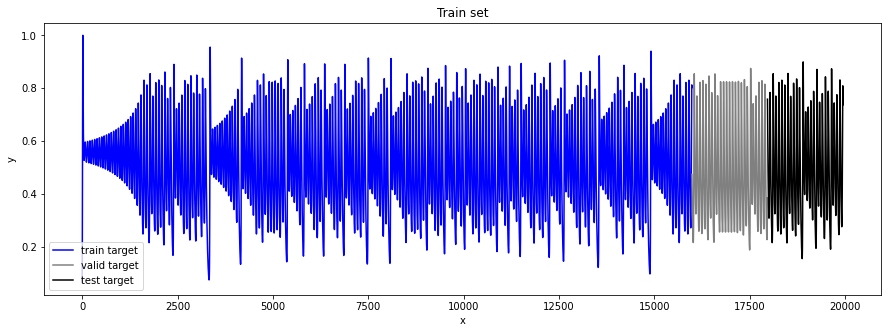

In [957]:
"""
splitted data
"""

plt.figure(figsize=(15, 5))

plt.plot(np.arange(y_train_2.shape[0]), y_train_2, color='blue', label='train target')

plt.plot(np.arange(y_train_2.shape[0], y_train_2.shape[0]+y_valid.shape[0]), y_valid,
         color='gray', label='valid target')

plt.plot(np.arange(y_train_2.shape[0]+y_valid.shape[0],
                   y_train_2.shape[0]+y_valid.shape[0]+y_test.shape[0]),
         y_test, color='black', label='test target')


plt.title('Train set')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best');

In [958]:
#from sklearn.utils import shuffle
#X_train, y_train = shuffle(X_train, y_train)


In [959]:
EPOCHS = 20
BATCH_SIZE = 64

import time

# Build and run model

In [960]:
import random, os, sys
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.python.keras.layers import Layer

In [961]:
class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape

In [962]:
class ScaledDotProductAttention():
    def __init__(self, d_model, attn_dropout=0.1):
        self.temper = np.sqrt(d_model)
        self.dropout = Dropout(attn_dropout)
    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x:K.batch_dot(x[0],x[1],axes=[2,2])/self.temper)([q, k])
        if mask is not None:
            mmask = Lambda(lambda x:(-1e+10)*(1-x))(mask)
            attn = Add()([attn, mmask])
        attn = Activation('softmax')(attn)
        attn = self.dropout(attn)
        output = Lambda(lambda x:K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn

In [963]:
class MultiHeadAttention():
    # mode 0 - big martixes, faster; mode 1 - more clear implementation
    def __init__(self, n_head, d_model, d_k, d_v, dropout, mode=0, use_norm=True):
        self.mode = mode
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        if mode == 0:
            self.qs_layer = Dense(n_head*d_k, use_bias=False)
            self.ks_layer = Dense(n_head*d_k, use_bias=False)
            self.vs_layer = Dense(n_head*d_v, use_bias=False)
        elif mode == 1:
            self.qs_layers = []
            self.ks_layers = []
            self.vs_layers = []
            for _ in range(n_head):
                self.qs_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.ks_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.vs_layers.append(TimeDistributed(Dense(d_v, use_bias=False)))
        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = LayerNormalization() if use_norm else None
        self.w_o = TimeDistributed(Dense(d_model))

    def __call__(self, q, k, v, mask=None):
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        if self.mode == 0:
            qs = self.qs_layer(q)  # [batch_size, len_q, n_head*d_k]
            ks = self.ks_layer(k)
            vs = self.vs_layer(v)

            def reshape1(x):
                s = tf.shape(x)   # [batch_size, len_q, n_head * d_k]
                x = tf.reshape(x, [s[0], s[1], n_head, d_k])
                x = tf.transpose(x, [2, 0, 1, 3])  
                x = tf.reshape(x, [-1, s[1], d_k])  # [n_head * batch_size, len_q, d_k]
                return x
            qs = Lambda(reshape1)(qs)
            ks = Lambda(reshape1)(ks)
            vs = Lambda(reshape1)(vs)

            if mask is not None:
                mask = Lambda(lambda x:K.repeat_elements(x, n_head, 0))(mask)
            head, attn = self.attention(qs, ks, vs, mask=mask)  
                
            def reshape2(x):
                s = tf.shape(x)   # [n_head * batch_size, len_v, d_v]
                x = tf.reshape(x, [n_head, -1, s[1], s[2]]) 
                x = tf.transpose(x, [1, 2, 0, 3])
                x = tf.reshape(x, [-1, s[1], n_head*d_v])  # [batch_size, len_v, n_head * d_v]
                return x
            head = Lambda(reshape2)(head)
        elif self.mode == 1:
            heads = []; attns = []
            for i in range(n_head):
                qs = self.qs_layers[i](q)   
                ks = self.ks_layers[i](k) 
                vs = self.vs_layers[i](v) 
                head, attn = self.attention(qs, ks, vs, mask)
                heads.append(head); attns.append(attn)
            head = Concatenate()(heads) if n_head > 1 else heads[0]
            attn = Concatenate()(attns) if n_head > 1 else attns[0]

        outputs = self.w_o(head)
        outputs = Dropout(self.dropout)(outputs)
        if not self.layer_norm: return outputs, attn
        # outputs = Add()([outputs, q]) # sl: fix
        return self.layer_norm(outputs), attn

In [964]:
class PositionwiseFeedForward():
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        self.w_1 = Conv1D(d_inner_hid, 1, activation='relu')
        self.w_2 = Conv1D(d_hid, 1)
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(dropout)
    def __call__(self, x):
        output = self.w_1(x) 
        output = self.w_2(output)
        output = self.dropout(output)
        output = Add()([output, x])
        return self.layer_norm(output)

    
class EncoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, enc_input, mask=None):
        output, slf_attn = self.self_att_layer(enc_input, enc_input, enc_input, mask=mask)
        output = self.pos_ffn_layer(output)
        return output, slf_attn
    
    
def GetPosEncodingMatrix(max_len, d_emb):
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)] 
        if pos != 0 else np.zeros(d_emb) 
            for pos in range(max_len)
            ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
    return pos_enc

def GetPadMask(q, k):
    ones = K.expand_dims(K.ones_like(q, 'float32'), -1)
    mask = K.cast(K.expand_dims(K.not_equal(k, 0), 1), 'float32')
    mask = K.batch_dot(ones, mask, axes=[2,1])
    return mask

def GetSubMask(s):
    len_s = tf.shape(s)[1]
    bs = tf.shape(s)[:1]
    mask = K.cumsum(tf.eye(len_s, batch_shape=bs), 1)
    return mask

In [965]:
class CustomeLearningSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomeLearningSchedule, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        param_1 = tf.math.rsqrt(step)
        param_2 = step * (self.warmup_steps**(-1.5))
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(param_1, param_2)

In [966]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1) 
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config
  

Text(0.5, 0, 'Train Step')

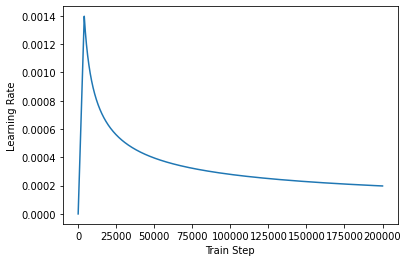

In [967]:
sample_learning_rate = CustomeLearningSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [968]:
D_MODEL=10

lr = CustomeLearningSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr,
                                     beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9)


In [969]:
def build_model():
    #inp = Input(shape = (SEQ_LEN, feat_size))
    
    time_embedding = Time2Vector(SEQ_LEN)
    
    in_seq = Input(shape=(SEQ_LEN, 3))
    x = time_embedding(in_seq)
    x = Concatenate(axis=-1)([in_seq, x])
    x, self_attn = EncoderLayer(
            d_model=D_MODEL,
            d_inner_hid=512, 
            n_head=8, 
            d_k=64,
            d_v=64, 
            dropout=0.2)(x)
        
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    conc = Dense(128, activation="relu")(conc)
    x = Dense(3, activation="sigmoid")(conc)      

    model = Model(inputs = in_seq, outputs = x)
    model.compile(
        loss = "mean_squared_error",  
        optimizer = optimizer,
        metrics=['mae', 'mape'])
    
    return model


In [970]:
multi_head = build_model()
multi_head.summary()

Model: "model_41"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_93 (InputLayer)          [(None, 10, 3)]      0           []                               
                                                                                                  
 tf.__operators__.getitem_17 (S  (None, 10, 3)       0           ['input_93[0][0]']               
 licingOpLambda)                                                                                  
                                                                                                  
 tf.math.reduce_mean_107 (TFOpL  (None, 10)          0           ['tf.__operators__.getitem_17[0][
 ambda)                                                          0]']                             
                                                                                           

In [971]:
tf.keras.utils.plot_model(multi_head, 
                          to_file="multi_head_net.png", 
                          show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [972]:


callback = EarlyStopping(monitor='val_loss',
                         patience=4,
                         restore_best_weights=True)


In [973]:
history = multi_head.fit(x=X_train, 
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         validation_data=(X_valid, y_valid),
                         callbacks=[callback])

Epoch 1/20


2022-01-27 11:50:29.866198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 0.0270 - mae: 0.1311 - mape: 33.0530

2022-01-27 11:50:53.948372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - 28s 47ms/step - loss: 0.0270 - mae: 0.1311 - mape: 33.0530 - val_loss: 0.0241 - val_mae: 0.1238 - val_mape: 30.1970
Epoch 2/20
250/250 [==============================] - 8s 30ms/step - loss: 0.0084 - mae: 0.0624 - mape: 15.5943 - val_loss: 0.0028 - val_mae: 0.0358 - val_mape: 9.1460
Epoch 3/20
250/250 [==============================] - 7s 29ms/step - loss: 0.0021 - mae: 0.0328 - mape: 7.8348 - val_loss: 7.7647e-04 - val_mae: 0.0216 - val_mape: 5.1948
Epoch 4/20
250/250 [==============================] - 7s 28ms/step - loss: 0.0019 - mae: 0.0301 - mape: 7.1888 - val_loss: 0.0122 - val_mae: 0.0777 - val_mape: 17.3697
Epoch 5/20
250/250 [==============================] - 7s 29ms/step - loss: 0.0020 - mae: 0.0296 - mape: 7.2006 - val_loss: 0.0025 - val_mae: 0.0386 - val_mape: 9.5836
Epoch 6/20
250/250 [==============================] - 8s 32ms/step - loss: 0.0010 - mae: 0.0227 - mape: 5.4679 - val_loss: 9.3150e-04 - val_mae: 0.0246 - val_mape: 5.2

In [876]:
multi_head.save_weights('./checkpoints/final_checkpoint_1')

In [877]:
multi_head.load_weights('./checkpoints/final_checkpoint_1')


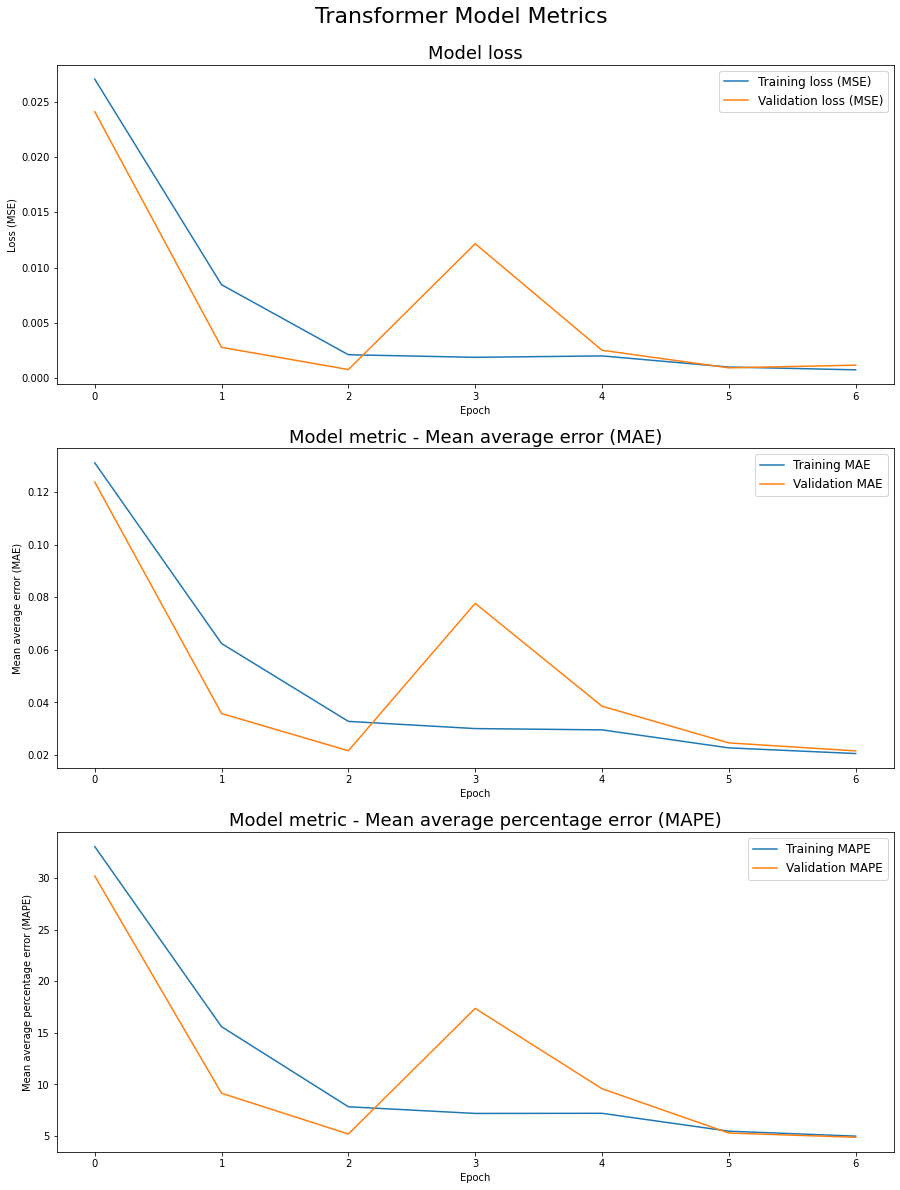

In [974]:
fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history.history['loss'], label='Training loss (MSE)')
ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (MAE)')
ax2.legend(loc="best", fontsize=12)

#Plot MAPE
ax3 = fig.add_subplot(313)
ax3.plot(history.history['mape'], label='Training MAPE')
ax3.plot(history.history['val_mape'], label='Validation MAPE')
ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Mean average percentage error (MAPE)')
ax3.legend(loc="best", fontsize=12)

In [975]:
from sklearn.preprocessing import StandardScaler

testPredict = multi_head.predict(X_valid)

#train_predict_new = np.zeros(shape=(len(testPredict), 3))
#train_predict_new[:,0] = testPredict[:,0]
#trainPredict = scaler.inverse_transform(train_predict_new )[:,0]

#testPredict = scaler.inverse_transform(testPredict)


predicted_multi_head = scaler.inverse_transform(testPredict)


#X_test.shape
testPredict.shape

2022-01-27 11:53:34.183159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


(1981, 3)

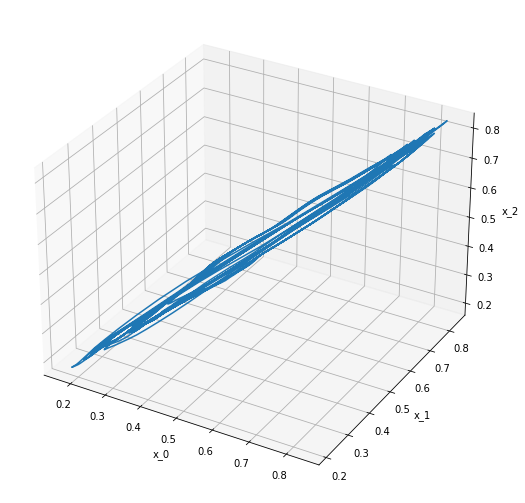

In [977]:
np.savetxt('output_lorenz3.csv',testPredict,delimiter=",")
trainPredict_dataset_like = pd.read_csv('output_lorenz3.csv',
                            names=["X", "Y", "Z"])
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111, projection = '3d')

x = trainPredict_dataset_like['X']
y = trainPredict_dataset_like['Y']
z = trainPredict_dataset_like['Z']

ax.set_xlabel("x_0")
ax.set_ylabel("x_1")
ax.set_zlabel("x_2")

ax.plot(x, y, z)
#ax.view_init(0, 0)



plt.show()

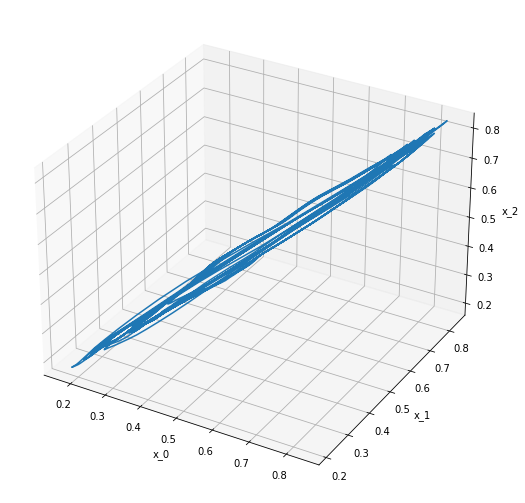

In [978]:
np.savetxt('output_lorenz2.csv',predicted_multi_head,delimiter=",")
trainPredict_dataset_like = pd.read_csv('output_lorenz2.csv',
                            names=["X", "Y", "Z"])
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111, projection = '3d')

x = trainPredict_dataset_like['X']
y = trainPredict_dataset_like['Y']
z = trainPredict_dataset_like['Z']

ax.set_xlabel("x_0")
ax.set_ylabel("x_1")
ax.set_zlabel("x_2")

ax.plot(testPredict[:,0],testPredict[:,1],testPredict[:,2])
#ax.view_init(0, 0)



plt.show()